#Overview



1.   Create your task HIT in MTurk platform
2.   Upload your data to S3 storage
3.   Generate CSV w/ your data
4.   Upload your CSV to MTurk, review and publish



# Quick Notes
* Spending limit is 100$ per day
* Simple image tagging reward can be set 0.03 USD
* More complex tasks - higher reward
* Masters qualification improves ans quality
* At least 3 turkers per HIT

**Video projects**  
* For video data use templates meant for video - image projects restrict file size.
* Convert `.mp4` videos to `.gif` GIFs if you don't need the audio.

<!-- ** Lighter
** Works smoothly in all browsers
** Avoids sync, looping related problems  -->

* Convert `.mp4` to `.webm` using `ffmpeg` (mp4 loading is different between browsers, which causes bugs).


#Detailed Instructions

## 1. Create task HIT

We begin with creating our task layout in the mturk platform.  
1. Go to [```https://requester.mturk.com/```](https://requester.mturk.com/)

 <img src="https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/figs/mturk_templates.png" width=700>


2. Browse the different templates, and choose the one closest to your task layout.   
    * The layout is editable moving forward
    * It's possible to combine elements from different templates


3. Hit the `Sign-in to Create Account` button. You will be forwarded to this screen.   
Create an account and add your CC details when asked.  

    <img src="https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/figs/mturk_login.png" width=400>   

    This part is might not go smoothly at first. That's normal.   
    
    * **Login Errors** - AWS often have a clash between logins and open sessions.   
    If stuck - try using a different email and/or work in incognito mode.  

    * **CC Errors** - many people get errors relating to the card: "insufficient funds", "you have reached the max limit" etc. It could be a result of using debit card instead of credit card.  

    Simply try a different card.


4. Set task Params
    
    - Simple image tagging reward can be set 0.03 USD
    - More complex tasks require higher reward.   
    - There is no official standard. I recommend publishing a small batch first, and see how fast it is picked up by workers.
    - If you published and the task is not getting picked up, it's possible to stop it in the middle and increase the reward.
    - Masters qualification improves ans quality
    - At least 3 turkers per HIT   
    * **NOTE**:  There is a spending limit of 100$ per day (per user, not per card).   
    Usually that's enough, but if you have many evaluation or working on multiple projects, plan your experiments accordingly.


<img src="https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/figs/task_setup.png" width=500>




5. **Build your task layout.**   
    a. Wording - phrase the key question in simple words. Be as clear as possible.
    
    Keep in mind that turkers come from all around the world.

    b. Add Instructions -   
    use the `short-instructions` and `full-instructions` section, and ask the turkers to read it before answering.

    This part should
    - Clarify words and metrics used in the main task that might have specific meaning.
    - Give examples of expected input - output
    - Images used for the instruction are not read from the csv. Provide a public url in the HTML code.

    - Example:

    <img src="https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/figs/task_layout.png" width=500>

    <img src="https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/figs/detailed_instructions.png" width=500>

    [HTML source code](https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/templates/video_classification.html) used for the above video action classification task.





##2. Upload Data to S3

Our servers are closed to the outside world, so we can't use any internal path as url (including `homedir/www`).   

The most straightforward way to give the images/video public url is to store it in AWS S3 cloud.

Go to [`https://aws.amazon.com/s3/`](`https://aws.amazon.com/s3/`) and follow instructions there.

![](https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/figs/s3_bucket.png)

##3. Generate CSV using Python

1. The CSV headers has to correspond to the variable names in the HTML task layout. For example,  

    ```%%html
    <!-- Your image file URLs will be substituted for the
    "image_url" variable below when you publish a batch
    with a CSV input file containing multiple image file URLs. -->

        <crowd-image-classifier
            src="${image_url}"
            categories="['Cat', 'Dog', 'Bird']"
            header="Choose the correct category"
            name="category">
    ```
2. Each line is a single HIT (task)

3. CSV Headers
- Your headers should include things like: `image_id`, `image_url`, `target_label`, and (depending on the task) any other relavant identifiers required for your analysis later on (the results CSV will include them)
- Upon uploading the csv you will get a warning about extra headers - ignore that. MTurk only uses the headers specified in the HTML task layout code.  



##4. Publish
1. Track the progress of your batch under "Manage" tab.
2. **Important**: You can download intermediate results and perform some analysis.
    - Useful when running evaluations close to the deadline.
    - Can be used as sanity check. if the results doesn't make sense, you can stop and fix the task. Unused credit is saved and will be reducted from the next batch you publish.

    


#Tips and Tricks

##Encode data instead of using cloud storage
To save costs you can also encode your samples to base64 and plant the encoded string in your CSV file under URL column. MTurk renders it as HTML so it is decoded to the user when loaded.

Caveats:
- Doesn't work well for videos
- If used, avoid manual edit of the csv




In [ ]:
import base64
from io import BytesIO
import imageio
import os
import csv
from PIL import Image, ImageDraw, ImageFont
from skimage import img_as_ubyte


def convert_image_to_base64(img_path):
    buffered = BytesIO()
    pil_img = Image.open(img_path)
    pil_img.save(buffered, format="png")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    decoding_prefix = 'data:image/png;base64,'
    return decoding_prefix + img_str

def convert_gif_to_base64(gif_path):
    gif_file = BytesIO()
    # gif = Image.open(gif_path)
    # gif.save(gif_file, format="gif")
    gif = imageio.mimread(gif_path)
    imageio.mimsave(gif_file, [img_as_ubyte(frame) for frame in gif], 'GIF') #, fps=original_fps)
    detect_base64 = 'data:image/gif;base64,{}'.format(base64.b64encode(gif_file.getvalue()).decode())
    return detect_base64



# Exercise 1 - Image Captions

In this exercise we'll load a toy dataset of 3 images.
Turkers are presented with two captions - ours and the baseline, and should choose which one describes the image best.


### Download the files

In [2]:
# Download example images and caption files

%%capture
!wget https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/exercise1/example_images/COCO_train2014_000000257345.jpg
!wget https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/exercise1/example_images/COCO_train2014_000000421488.jpg
!wget https://raw.githubusercontent.com/dekelio/Tutorials/main/AMT/exercise1/example_images/COCO_train2014_000000575649.jpg
!wget https://github.com/dekelio/Tutorials/blob/main/AMT/exercise1/captions_bsln.csv
!wget https://github.com/dekelio/Tutorials/blob/main/AMT/exercise1/captions_ours.csv

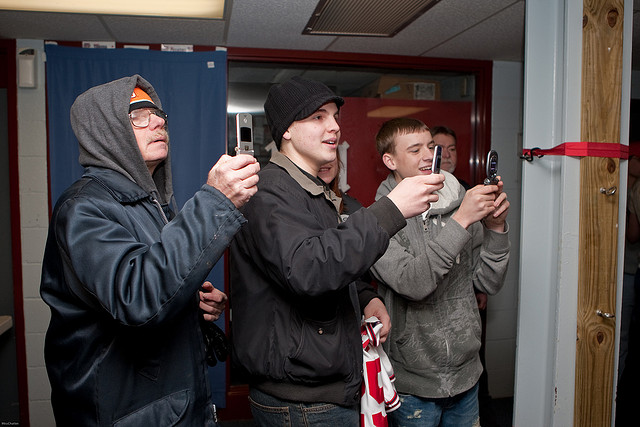

Ours:  three people
Baseline:  three apples


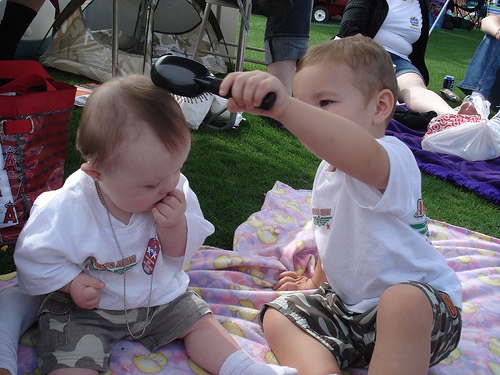

Ours:  two babies
Baseline:  two planet orbiting around sun


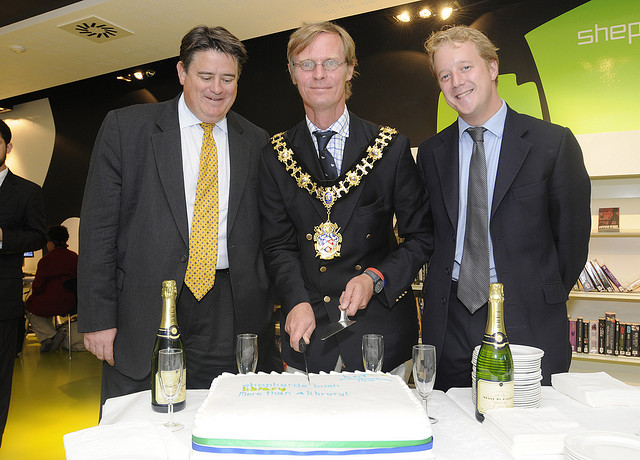

Ours:  people celebrating
Baseline:  pizza with pineapple toppings


In [38]:
# @title Quick look at the data
from IPython.display import Image
import pandas as pd

def read_desc(fname, csv_cols=["image_id", "caption"]):
    df = pd.read_csv(fname,  sep='^([^,]+),', engine='python', names=csv_cols)
    return dict(zip(df.image_id.values, df.caption.values))

caps_ours = read_desc("captions_ours.csv")
caps_bsln = read_desc("captions_bsln.csv")

image_list = [ f for f in os.listdir('.') if f.endswith('.jpg') ]

for img in image_list:
  display(Image(f'./{img}', width=200))
  print('Ours: ', caps_ours[img.split('_')[-1].split('.')[0]])
  print('Baseline: ', caps_bsln[img.split('_')[-1].split('.')[0]])


### Build the HTML task layout

### Generate your input CSV using Python
- Here, we read all the relevant results files (in our case, two result files) and reorganize it in a way that makes sense, given the task layout.
- we also have to provide the public urls of the images

In [40]:
# Suggegsted sol
# CSV Headers can be ["image_id", "image_url", "caption1", "caption2", "target"] where target gets the value of either 1 or 2.
# we need to make sure that we shuffle the captions order (so that "ours" wont always apeare first)


### Analyze Results

Download the results csv

* The following columns are generated and recorded by mTurk:   

    `HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,AutoApprovalDelayInSeconds,Expiration,NumberOfSimilarHITs,LifetimeInSeconds	AssignmentId, WorkerId,AssignmentStatus,AcceptTime,SubmitTime,AutoApprovalTime, ApprovalTime, RejectionTime,RequesterFeedback, WorkTimeInSeconds,LifetimeApprovalRate, Last30DaysApprovalRate, Last7DaysApprovalRate, ...,	Approve, Reject`

* MTurk appends `Input.` to all the variables coming from the uploaded csv:
`Input.image, Input.image_url, Input.image_caption1,  Input.image_caption2, Input.target`

* MTurk appends `Answer.` to all the answers from turks:
`Answer.summary`  

* `WorkerId`,`WorkTimeInSeconds` can help identify and filter out problematic turkers.


 Compute the accuracy of each model.